In [1]:
%matplotlib inline
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import seaborn as sns
from scipy import sparse, stats, spatial
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

from sklearn.decomposition import NMF, LatentDirichletAllocation

Load the entire features dataframe

In [2]:
data = pickle.load(open('../DataEnriching/data.pickle','rb'))
data = data.reset_index()
data = data.set_index("ISO2")


lang_feature_df = pd.read_pickle('../LinkingLanguages/stand_country_dist_languages.pkl')
fligh_routes_df = pd.read_pickle('../GeoMetrics/flight_routes_std.pickle')
hop_distance_df = pd.read_pickle('../GeoMetrics/hop_distance_std.pickle')
neighbor_influence_df = pd.read_pickle('../GeoMetrics/neighbor_influence.pickle')
dist_feature_df = pd.read_pickle('../GeoMetrics/real_distance_std.pickle')
religion_and_more_df = pd.read_pickle('../DataEnriching/Pickles for Milestone 3/6_feature_df.pickle')

# Load the number of internet users
internet_users = pickle.load(open('internet_users.pickle','rb'))
internet_users.set_index("ISO2", inplace = True)
internet_users.replace("unknown", -1, inplace = True)
internet_users = internet_users["Internet users"].astype(np.float)

# drop the name column : 
religion_and_more_df.drop('name',axis=1,inplace=True)

#carefull the number of coutries is not the same in every pickle.
features_df = pd.concat([lang_feature_df,
           fligh_routes_df,
           hop_distance_df,
           neighbor_influence_df,
          dist_feature_df,
          religion_and_more_df],axis=1)
#features_df.sort_index(axis=1,inplace=True)

features_df.loc[:,("Internet users")] = internet_users
med = np.median([x for x in features_df.loc[:,("Internet users")].tolist() if not np.isnan(x)])
features_df.loc[:,("Normalized internet users")] = med

for country in tqdm(features_df.index):
    users = features_df.loc[country,:]["Internet users"][0]
    pop = features_df.loc[country, :]["POP"][0]
    val = min(users, pop)/pop
    med_val =  min(med, pop)/pop
    #print(features_df.loc[country,"Normalized internet users"])
    
    if  (users!= -1) and (not(np.isnan(users))) and (not(np.isnan(pop))):
        if not np.isnan(val):
            features_df.loc[country,("Normalized internet users")] = val  
        else :
            features_df.loc[country,("Normalized internet users")]  = med_val
    else :
        features_df.loc[country,("Normalized internet users")]  = med_val


#print(features_df.columns)
features_df.head()

/Users/laila/anaconda/envs/ADA/lib/python3.6/site-packages/ipykernel/__main__.py:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
100%|██████████| 248/248 [00:01<00:00, 243.52it/s]


language_dist                                                       \
              AW    AF    AO    AI    AX    AL    AD    AE    AR   AM   
AD           4.0  16.0   4.0  19.0   3.0   3.0   0.0   5.0   3.0  3.0   
AE           5.0  10.0   5.0   4.0   4.0   4.0   5.0   0.0   4.0  4.0   
AF          17.5   0.0  20.0  15.0  13.0   7.0  16.0  10.0  18.0  9.5   
AG          13.0  15.0   3.0   0.0   3.0  10.0  19.0   4.0   3.0  7.5   
AI          13.0  15.0   3.0   0.0   3.0  10.0  19.0   4.0   3.0  7.5   

              ...                       religion                    \
              ...            Syncretic religions Animist religions   
AD            ...                            0.0          0.000000   
AE            ...                            0.0          0.000000   
AF            ...                            0.0          0.000099   
AG            ...                            NaN               NaN   
AI            ...                            NaN               NaN   

                                      area         POP 2016_gdp_capita  \
   Non-religious Other religions                                         
AD      0.079600          0.0009     468.0     85500.0             NaN   
AE      0.013599          0.0041   83600.0   6236650.0    37622.207458   
AF      0.002000          0.0014  652230.0  27000000.0      561.778746   
AG           NaN             NaN     442.0         NaN    14353.378814   
AI           NaN             NaN      91.0         NaN             NaN   

   gov_type_num Internet users Normalized internet users  
                                                          
AD         -1.0           83.0                  0.000971  
AE         -1.0      5274000.0                  0.845646  
AF          1.0      2690000.0                  0.099630  
AG         -1.0           60.0                       NaN  
AI         -1.0           12.0                       NaN  

[5 rows x 1258 columns]

Functions used to process a given event

In [9]:
def load_tweets(event, country_code):
    plt.figure(figsize = (15,10))
    # Loading the Number of tweets of the event in turkey per country
    summary_tweets = pickle.load(open('../../../Project Data/Tweets/{}/Geocoded/summary.pickle'.format(event), 'rb'))
    #plot = sns.barplot(summary_tweets.index,summary_tweets.text)
    return summary_tweets


def event_specific_features(country_code, summary_tweets):
    country_features_df = pd.concat([lang_feature_df.loc[:,("language_dist",country_code)],
                           fligh_routes_df.loc[:,("flight_routes",country_code)],
                           hop_distance_df.loc[:,("hop_distance",country_code)],
                           neighbor_influence_df.loc[:,("neighbor_influence",country_code)],
                           dist_feature_df.loc[:,("real_distance",country_code)], 
                           summary_tweets.loc[:,"text"],
                           data.loc[:,["area", "2016_gdp_capita", "gov_type_num", "POP", "2016_gdp_total"]],
                           features_df.loc[:,("Normalized internet users")],
                           features_df.loc[:,("Internet users")]],axis=1)
    #features_df.sort_index(axis=1,inplace=True)

    #print(list(country_features_df.columns))
    country_features_df.head(29)
    country_features_df.columns = ['language_dist', 'flight_routes', 'hop_distance', 'neighbor_influence',\
                              'real_distance', 'text', 'area', '2016_gdp_capita', 'gov_type_num',\
                              'POP', '2016_gdp_total', 'internet_users', 'norm_internet_users']
    country_features_df.flight_routes = country_features_df.flight_routes.astype(np.float)
    country_features_df.neighbor_influence = country_features_df.neighbor_influence.astype(np.float)

    country_features_df.drop([country_code], inplace = True)
    return country_features_df

def plot_correlations_with_regression(country_features_df):
    fig = plt.figure(figsize = (15,20))

    y_all = country_features_df.loc[:,'text'].tolist()

    for idx, column in enumerate(country_features_df.columns):
        ax = plt.subplot(len(country_features_df.columns)//3+1, 3, idx+1)
        x_all = country_features_df.loc[:,column].tolist()
        x = list()
        y = list()

        for i in range(len(x_all)):
            if (not np.isinf(x_all[i])) and (not np.isnan(x_all[i])):
                x.append(x_all[i])
                y.append(y_all[i])

        ax.plot(x, y, 'o', label='original data')
        slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
        print("{} regression, r^2 {:.3f}".format(column, r_value**2))
        ax.plot(np.array(x), intercept + slope*np.array(x), '--r', label='fitted line')
        ax.legend()
        ax.x_label(column)
        ax.y_label("number of tweets")
        plt.title("{} : r^2 {:.3f}".format({}) )
        
        

def analyse_event(event_name, country_code):
    summary_tweets = load_tweets(event_name, country_code)
    country_features_df = event_specific_features(country_code,summary_tweets)
    #print(country_features_df.corr())
    sns.heatmap(abs(country_features_df.corr("spearman")[["text"]]),annot=True)
    plot_correlations_with_regression(country_features_df)

Load the tweets for an event

language_dist regression, r^2 0.000
flight_routes regression, r^2 0.034
hop_distance regression, r^2 0.110
neighbor_influence regression, r^2 0.000
real_distance regression, r^2 0.002
text regression, r^2 1.000
area regression, r^2 0.113
2016_gdp_capita regression, r^2 0.085
gov_type_num regression, r^2 0.003
POP regression, r^2 0.060
2016_gdp_total regression, r^2 0.666
internet_users regression, r^2 0.063
norm_internet_users regression, r^2 0.133


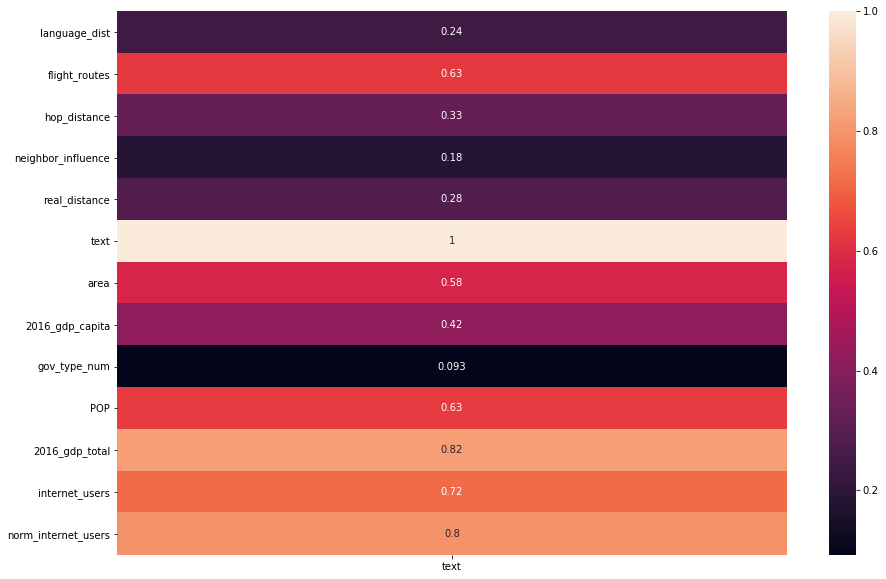

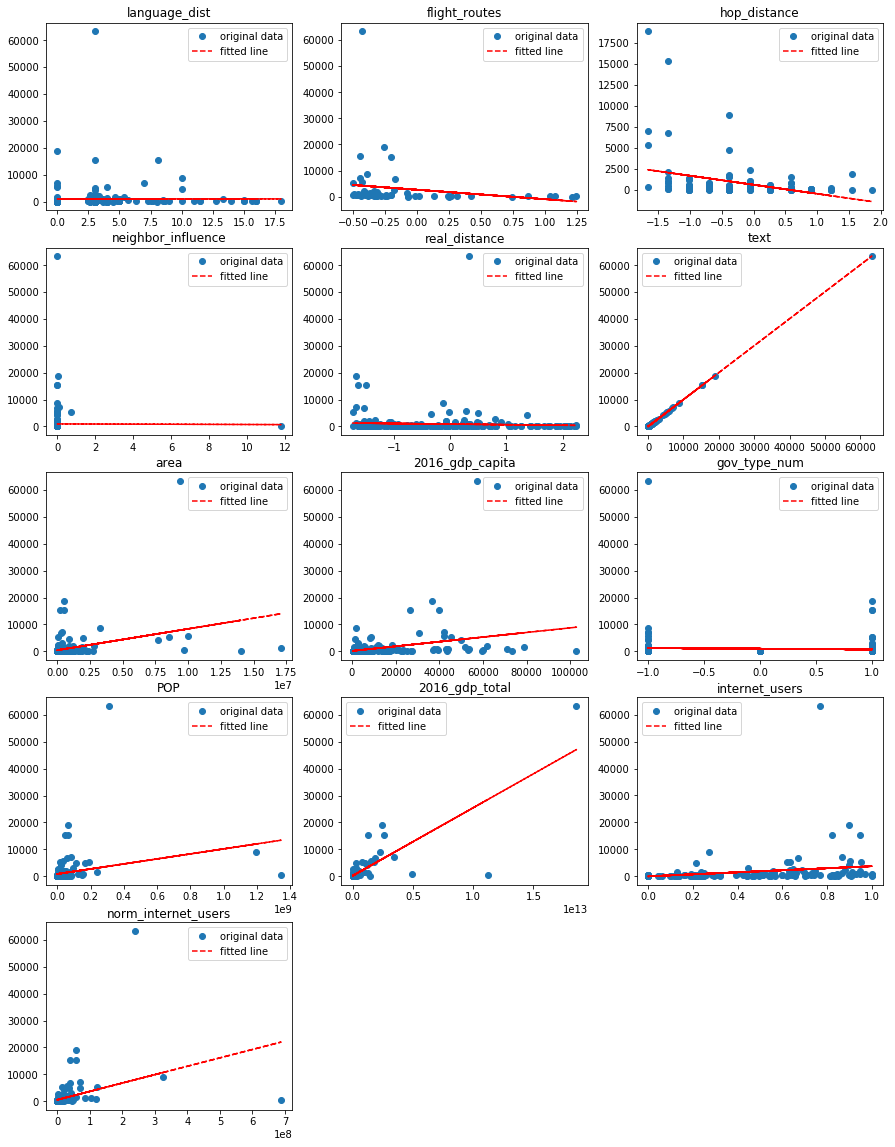

In [14]:
analyse_event("Bruxelles", "BE")

language_dist regression, r^2 0.000
flight_routes regression, r^2 0.002
hop_distance regression, r^2 0.121
neighbor_influence regression, r^2 0.000
real_distance regression, r^2 0.004
text regression, r^2 1.000
area regression, r^2 0.191
2016_gdp_capita regression, r^2 0.143
gov_type_num regression, r^2 0.007
POP regression, r^2 0.044
2016_gdp_total regression, r^2 0.361
internet_users regression, r^2 0.147
norm_internet_users regression, r^2 0.089


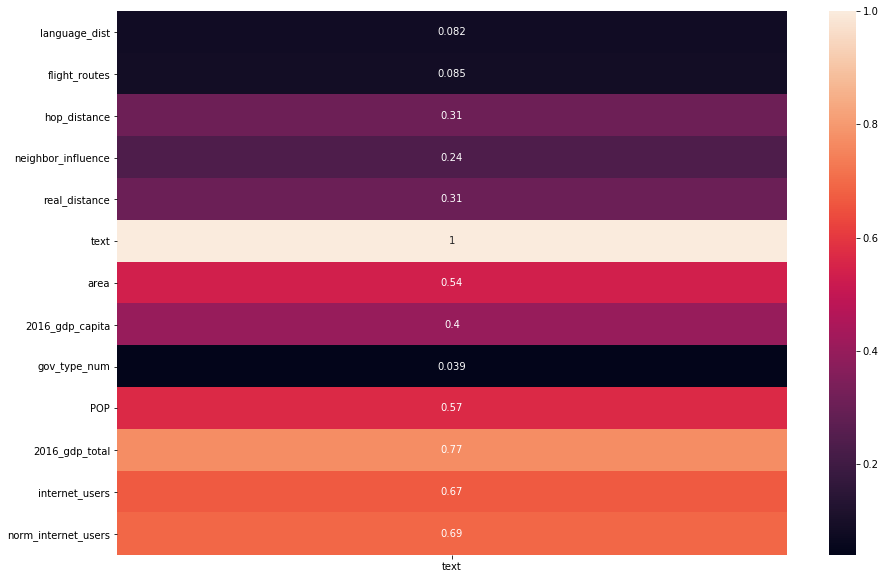

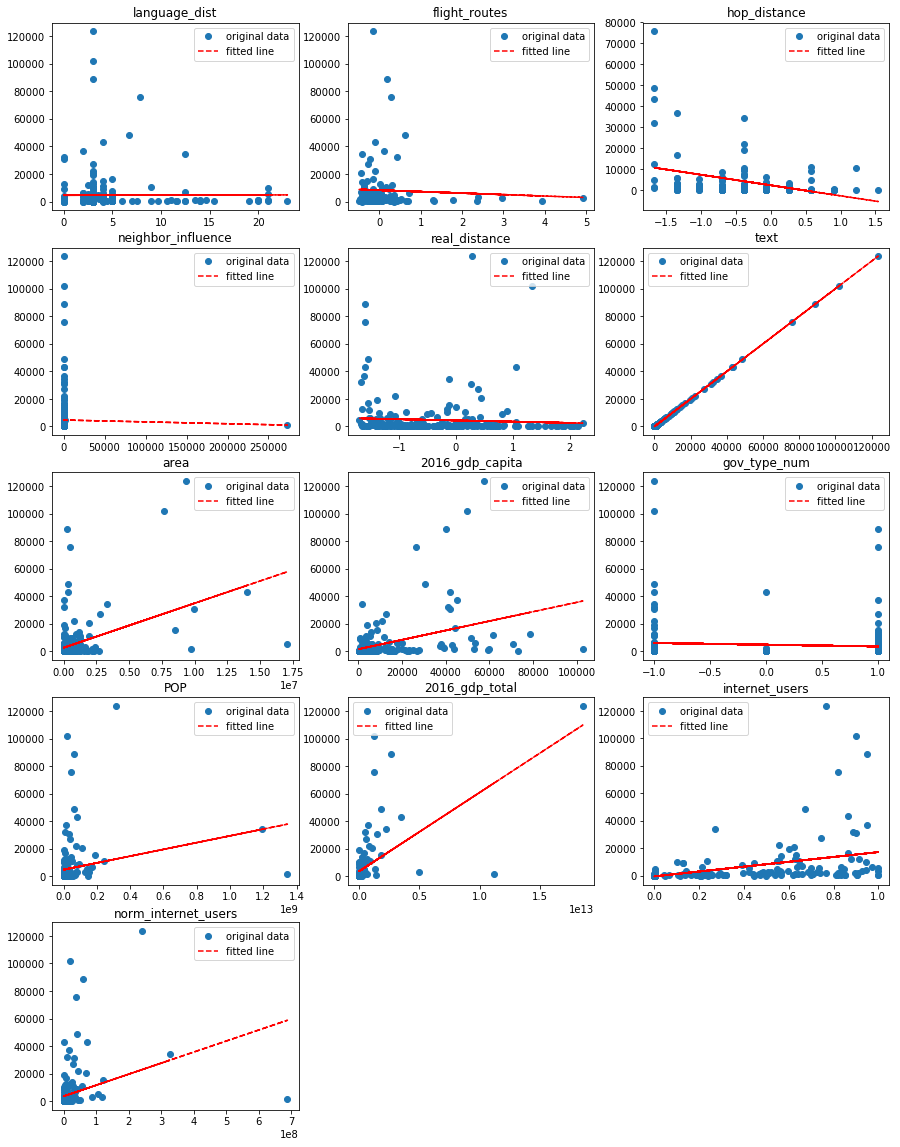

In [11]:
analyse_event("Charlie-Hebdo", "FR")

language_dist regression, r^2 0.019
flight_routes regression, r^2 0.001
hop_distance regression, r^2 0.056
neighbor_influence regression, r^2 0.001
real_distance regression, r^2 0.039
text regression, r^2 1.000
area regression, r^2 0.032
2016_gdp_capita regression, r^2 0.040
gov_type_num regression, r^2 0.002
POP regression, r^2 0.012
2016_gdp_total regression, r^2 0.107
internet_users regression, r^2 0.073
norm_internet_users regression, r^2 0.021


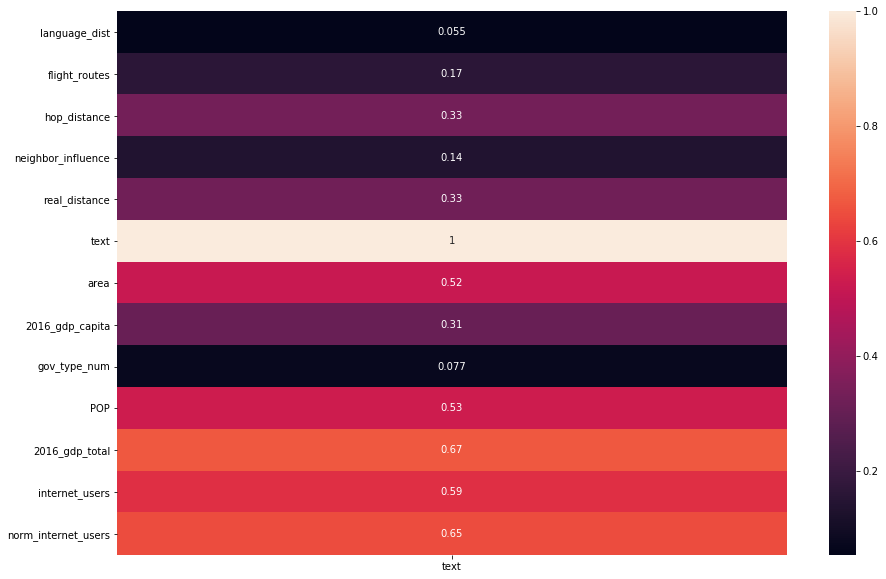

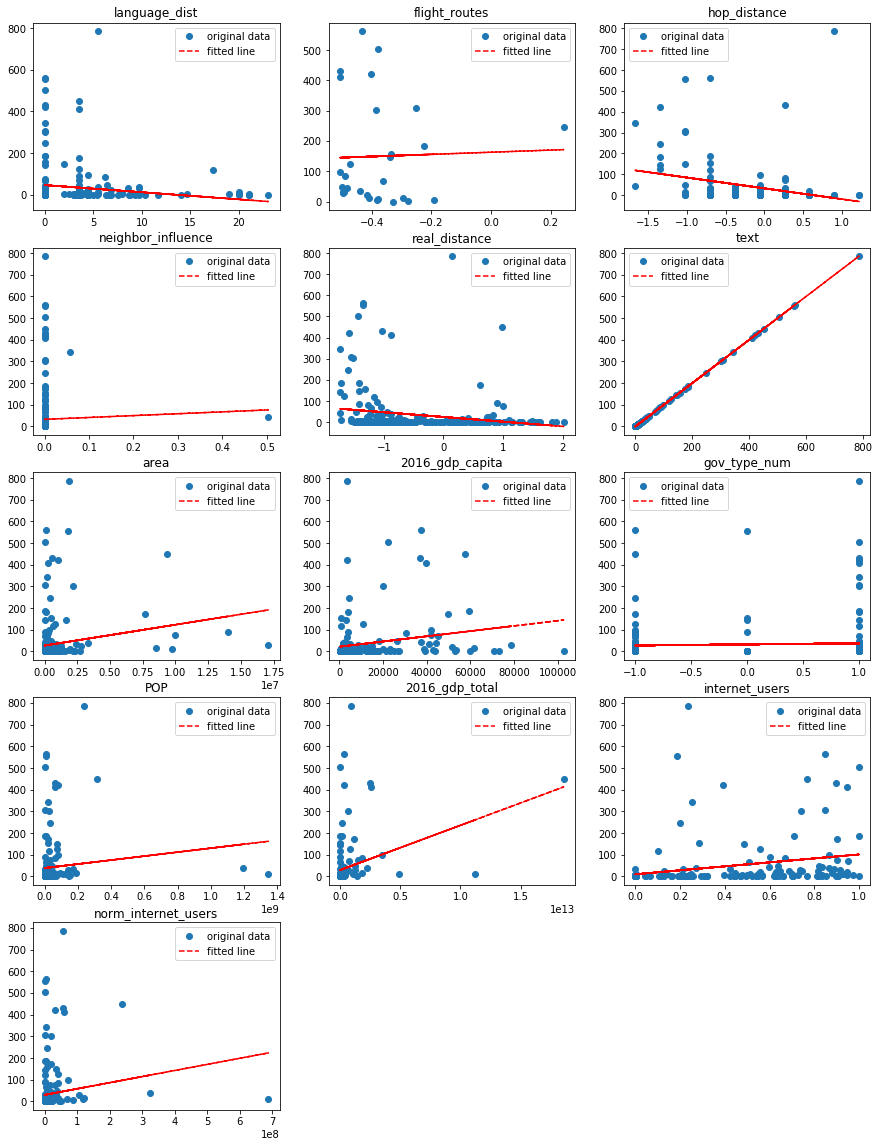

In [12]:
analyse_event("Lebanon", "LB")

language_dist regression, r^2 0.002
flight_routes regression, r^2 0.131
hop_distance regression, r^2 0.004
neighbor_influence regression, r^2 0.000
real_distance regression, r^2 0.000
text regression, r^2 1.000
area regression, r^2 0.155
2016_gdp_capita regression, r^2 0.101
gov_type_num regression, r^2 0.006
POP regression, r^2 0.039
2016_gdp_total regression, r^2 0.432
internet_users regression, r^2 0.103
norm_internet_users regression, r^2 0.090


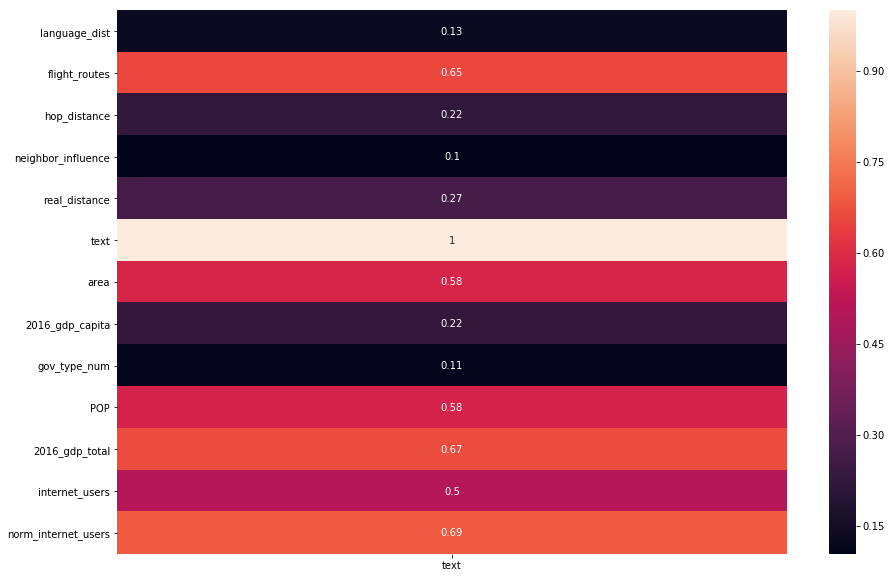

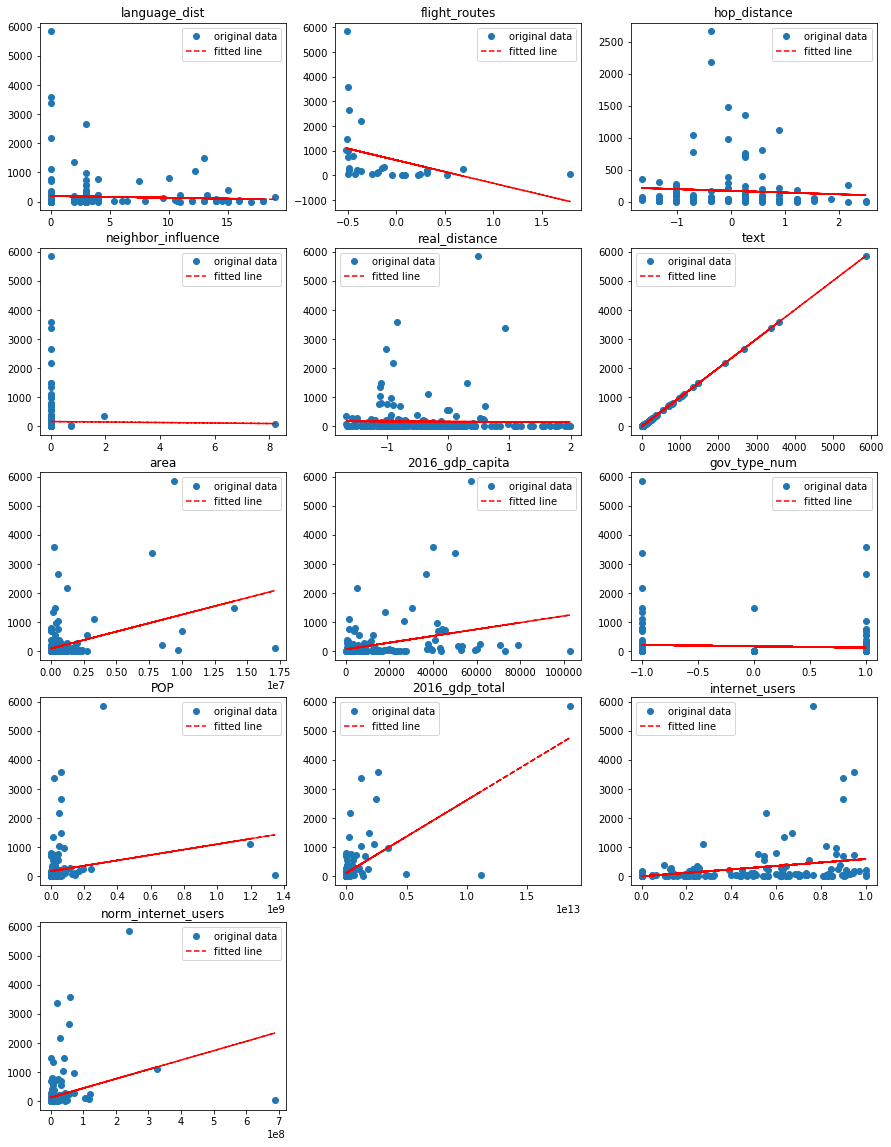

In [13]:
analyse_event("Nigeria-Attack", "NG")